# Analysis of personal inbox

The idea behind this notebook is to perform EDA and find relevant trends, facts and insights into the use of my personal inbox in Gmail

The process will be divded into:
1. Importing packages
2. Parse information from mbox format to csv
3. Clean data
4. Perform EDA
5. Conclusions

## Importing packages

In [1]:
import mailbox
import unicodecsv as csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

## Read data from mbox file to dataframe

In [2]:
file_name="C:/Users/frano/Documents/Personal/ML/Gmail_Analysis/fob_gmail.mbox"

In [3]:
writer = csv.writer(open("C:/Users/frano/Documents/Personal/ML/Gmail_Analysis/fob_gmail.csv", "wb"))

In [4]:
all_mail = mailbox.mbox(file_name)

In [5]:
# find what parameters are stored in Gmail mbox file
for key in all_mail[0].keys():
    print(key)

X-GM-THRID
X-Gmail-Labels
Delivered-To
Received
X-Google-Smtp-Source
X-Received
ARC-Seal
ARC-Message-Signature
ARC-Authentication-Results
Return-Path
Received
Received-SPF
Authentication-Results
DKIM-Signature
DKIM-Signature
From
Message-ID
Subject
MIME-Version
Content-Type
To
Date
X-LinkedIn-Class
X-LinkedIn-Template
X-LinkedIn-fbl
X-LinkedIn-Id
List-Unsubscribe
Feedback-ID
Require-Recipient-Valid-Since


From the developers website from Google (<https://developers.google.com/gmail/imap/imap-extensions>) we find that the following variables have the most information that can show patterns of use:

* Date: Time stamp for the email
* To: Who the email was directed to
* From: Who composed the email
* Subject: Subject line for the email
* Message-ID: unique email identifies so that it can be accessed across multiple folders
* Content-type: description of the email
* X-GM-THRID: a unique ID for messages in a single thread
* X-GM-LABELS: identify folder of the email, can be used to differentiatie between incoming and outgoing messages

In [6]:
# Write header row
writer.writerow(["Date","To","From","Subject","Message-ID","Content-Type","X-Gmail-Labels","X-GM-THRID"])
# Write contents
for message in all_mail:
    writer.writerow([message['Date'],message['To'], message['From'],message['Subject'],message['Message-ID'],message['Content-Type'],message['X-Gmail-Labels'],message['X-GM-THRID']])

For reference the original MBOX file was **10.99 GB** and the CSV with only the chosen fields is **16.4 MB**

# Cleaning Data

In [7]:
# Read Data into a pandas data frame and show the first rows
gmail_df=pd.read_csv("C:/Users/frano/Documents/Personal/ML/Gmail_Analysis/fob_gmail.csv")
gmail_df.head()

,Date,To,From,Subject,Message-ID,Content-Type,X-Gmail-Labels,X-GM-THRID
0,"Mon, 28 Jun 2021 12:34:18 +0000 (UTC)",Francisco Obando <fran.obando@gmail.com>,Jacob Morgan via LinkedIn <newsletters-noreply...,How to Future Proof Your Life and Your Career,<202753962.2512353.1624883658879.JavaMail.app@...,"multipart/alternative; \n\tboundary=""----=_Par...","Inbox,Important,Opened,Category Updates",1703814011931843695
1,"Sat, 26 Jun 2021 08:02:59 +0000","""fran.obando@gmail.com"" <fran.obando@gmail.com>",Fumigaciones Ecuador <notification@productosbi...,"=?utf-8?Q?Murci=C3=A9lagos=3A?= Limpieza,\n =?...",<50e0254009961be00a4d51470243e6ecd3f5f048@prod...,"multipart/alternative;\n boundary=""_=_swift_16...","Spam,Category Promotions,Unread",1703826251736387982
2,"Fri, 25 Jun 2021 20:05:13 -0700",fran.obando@gmail.com,Google Alerts <googlealerts-noreply@google.com>,Alerta de Google: industria ecuador,<0000000000006469bc05c5a286ba@google.com>,"multipart/alternative; boundary=""0000000000006...","Important,Trash,Opened,Category Updates",1703597009506298415
3,"Thu, 24 Jun 2021 00:38:29 +0000","""fran.obando@gmail.com"" <fran.obando@gmail.com>",Ligia Barahona <ligiabarahona@hotmail.com>,\n =?iso-8859-1?Q?=BFBUSCANDO_PROVEEDOR_DE_SEG...,\n <BN8PR18MB2916895C301483914793AC86BD079@BN8...,"multipart/related;\n\tboundary=""_004_BN8PR18MB...","Spam,Category Personal,Unread",1703406597449281529
4,"Fri, 25 Jun 2021 04:08:31 +0000","""Francisco Obando"" <fran.obando@gmail.com>","""Machine Learning"" <no-reply@t.mail.coursera.org>",Updates to Programming Assignments,<36.3C.31809.FB655D06@an.mta2vrest.cc.prd.spar...,"multipart/alternative; boundary=""_----XCiIuAQj...","Inbox,Important,Opened,Category Updates",1703510395631644382


In [8]:
gmail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46228 entries, 0 to 46227
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            46108 non-null  object
 1   To              44801 non-null  object
 2   From            46225 non-null  object
 3   Subject         46038 non-null  object
 4   Message-ID      46108 non-null  object
 5   Content-Type    46168 non-null  object
 6   X-Gmail-Labels  45077 non-null  object
 7   X-GM-THRID      46228 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 2.8+ MB


From the first rows of data we can see that the following actions must be taken:

1. Parse the Date column into a datetime data type
2. Clean To and From columns to only email (remove names and <>)
3. Check Message-ID is a unique identifier

### Parse Date column

In [9]:
# Parse date to datetime type
#gmail_df["Date"]=pd.to_datetime(gmail_df["Date"],format="%a, %d %b %Y %H:%M:%S %z",errors="coerce",utc=True)
gmail_df['Date'] = gmail_df['Date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

C:\Users\frano\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname CEST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\frano\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\frano\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identif

From the warnings in changing to datetime type we find that there are email with time zones different than UTC, if we filter by those values that are UTC we can see the percentage of messages that will be retained

In [10]:
# Keep rows where time is valid
gmail_df=gmail_df[gmail_df["Date"].notna()]

In [11]:
gmail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45339 entries, 0 to 46227
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            45339 non-null  datetime64[ns, UTC]
 1   To              44032 non-null  object             
 2   From            45336 non-null  object             
 3   Subject         45269 non-null  object             
 4   Message-ID      45339 non-null  object             
 5   Content-Type    45279 non-null  object             
 6   X-Gmail-Labels  44188 non-null  object             
 7   X-GM-THRID      45339 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(6)
memory usage: 3.1+ MB


We see that the original data frame had 46108 non-null entries and the new dataframe has 45339 non-null entries for the Date column, or a **1.66%** loss of data, which for this exploratory analysis can be accepted.

Check range of dates in the dataframe

In [12]:
print(gmail_df["Date"].min())
print(gmail_df["Date"].max())

2006-03-15 02:41:13+00:00
2030-11-15 14:47:06+00:00


Since there is the maximum date in 2030 (the analysis is done in 2021), there must be an error when parsing the date. Check and count dates past Dec 31 2021

In [13]:
gmail_df[gmail_df["Date"]>pd.Timestamp(year=2022, month=1, day=1, hour=0,tz='UTC')]

,Date,To,From,Subject,Message-ID,Content-Type,X-Gmail-Labels,X-GM-THRID
32221,2030-11-15 14:47:06+00:00,=?utf-8?B?Y2FybG9zcGlub2NhYnJlcmE=?= <carlospi...,=?utf-8?B?c2FsZXMxNw==?= <sales17@torshare.com>,=?utf-8?B?UmU6STJFIE5ldyBQcm9qZWN0?=,<etPan.727fe56a.6b8b4567.1e79@iPhone>,"text/html; charset=""UTF-8""","Inbox,Important,Opened,Category Personal",1517917357411131322


Delete this row with index 32221

In [14]:
gmail_df.drop(32221,inplace = True)

### Clean email formatting

To extract the emails in the From and To columns, since the length of emails and names can change from one entry to another the easiest way to get the email will be by using regular expressions to extract the string between the <>. There are cases, in particular in the To column, where the email is just the email address, in which case that email must be retained. Finally there are less non-null objects in the To column than the Date column, meaning there will be NaN as some values. 

In [15]:
def get_emails(string):
    # If it is a valid string
    if type(string)==str:
        # Get match object between <>
        email = re.search('<.+?>',string)
        # if there is no match because the email was directly read return the email
        if email is None:
            return string
        return email[0][1:-1]
    # If it is a NaN return the NaN
    else:
        return string

In [16]:
gmail_df["To"]=gmail_df["To"].apply(lambda x: get_emails(x))
gmail_df["From"]=gmail_df["From"].apply(lambda x: get_emails(x))
gmail_df["To"]=gmail_df["To"].str.lower()
gmail_df["From"]=gmail_df["From"].str.lower()

### Validate Message-ID as unique identifier

In [17]:
gmail_df["Message-ID"].value_counts()

<e29671c5e04dc7469ac97a57f2d9bfb0@s12.dptagent.net>                                                                                                                                             4
<7688ccb47d5a157120122c459633b83d@ydspower.com>                                                                                                                                                 2
<!&!GAAAAAAAAABafS8+OibqRKhekjBpA/sswoAAABgAAAAAAAAAWn0vPjom6kSoXpIwaQP7LGRdMQAYAAAAAAAAAFp9Lz46JupEqF6SMGkD+yzCgAAAEAAAAAoINHZDEKpMgwGE1v6tH1ETAAAARlc6IExVTUlOQVJJQVMgRkFMVA==@i2e.com.ec>    2
<201601060852548121704@wawui.cn>                                                                                                                                                                2
<!&!AAAAAAAAAAAYAAAAAAAAAHG3fjz4JcJFiTm/DnSJ6h7CgAAAEAAAALGGJR1XCdNAioh6/XVSbDABAAAAAA==@camce-ec.com>                                                                                          2
                              

Since there are repeated counts for the values (45328 different values vs the 45339 expected if it were a unique identifier) it does not represent a unique identifier for emails in the data set. This must be validated, as the 11 row diffence might be due to parsing from the mbox file, being a very long identifier which might cause overflow, or some other artifact. 

# Exploratory Data Analysis

To begin the analysis we will create some auxiliary columns from the Date column, to aggregate the messages by day, day of the week, week, and year

In [18]:
# Create day of week, hour and year columns to aggregate
gmail_df["Hour"]=gmail_df["Date"].dt.hour
gmail_df["DoW"]=gmail_df["Date"].dt.dayofweek
gmail_df["Week"]=gmail_df["Date"].dt.isocalendar().week
gmail_df["Year"]=gmail_df["Date"].dt.year

From the X-Gmail-Labels column it can be seen that a message can be in several folders. To simplify the column will be transformed into a binary variable either "Inbox" or "Sent". Since not every row has the label "Inbox" or "Sent" (in some cases the label is a NaN), the rule to create the variable will be that the email will be label "Inbox" if the sender is different from the account.

In [19]:
my_email="fran.obando@gmail.com"
gmail_df["Labels"]=gmail_df["From"].apply(lambda x: "Sent" if x==my_email else "Inbox")

Some of the questions we can ask about this data set are:

* Are there patterns to the time of messages? Does it depend on inbox or sent category?
* What is the average thread length of this mailbox?
* Are there common topics in the subject line?
* What are the most common email addresses that mails are sent to? received from?
* Are there any peculiar messages?

### Aggregate number of messages by time

<AxesSubplot:xlabel='Hour'>

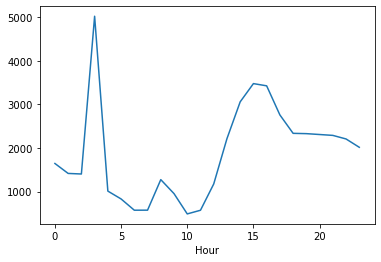

In [20]:
gmail_df.groupby("Hour").count()["Date"].plot()

There is a significant increase in emails received or sent around 3am and 3pm

<AxesSubplot:xlabel='DoW'>

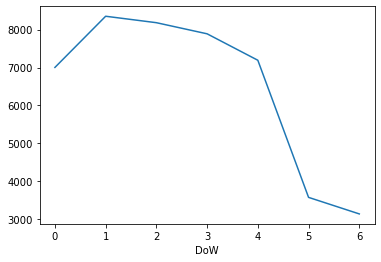

In [21]:
gmail_df.groupby("DoW").count()["Date"].plot()

There is a significant decrease in the amount of emails sent or received during the weekend. 

<AxesSubplot:xlabel='Week'>

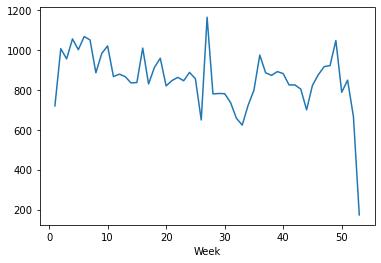

In [22]:
gmail_df.groupby("Week").count()["Date"].plot()

From the weekly use of emails there is a peak around week 28 (July), followed by a dip around week 32 (August). This could be an indicator of preparations for summer vacations. There is also a dip for the end of the year, most likely related to holidays. 

<AxesSubplot:xlabel='Year'>

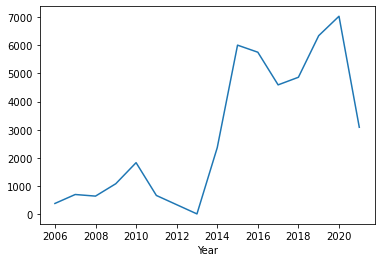

In [23]:
gmail_df.groupby("Year").count()["Date"].plot()

The yearly evolution shows a significant increate in use of Gmail around 2015. This corresponds to the year I started work as a project manager. 

#### Inbox vs Sent emails

In [24]:
# Separate into inbox and sent 
sent=gmail_df[gmail_df["Labels"]=="Sent"]
received=gmail_df[gmail_df["Labels"]=="Inbox"]

To facilitate side by side plots functions and classes will be created to make it the comparison easier

In [25]:
# Function to show the time emails are marked as a function of the year
def plot_time_year(df,ax,title=""):
    df.plot.hexbin(x="Year",y="Hour",ax=ax,gridsize=(15,24))
    ax.set_title(title)

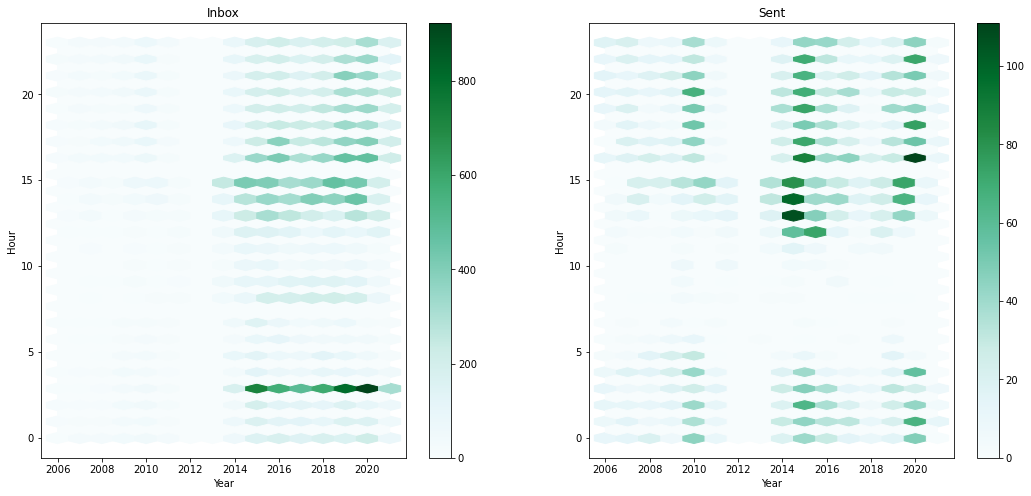

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(18,8))
plot_time_year(received,ax1,"Inbox")
plot_time_year(sent,ax2,"Sent")

From the plots it can be seen that there is a drop in number of emails in 2013. Also that for inbound email they seem to be pretty evenly distributed through out the day. However, for composed emails there is a clear drop between 9 am and 10 am

In [27]:
# Function to show the time emails are marked as a function of the day of the week
def plot_time_DoW(df,ax,title=""):
    df.plot.hexbin(x="DoW",y="Hour",ax=ax,gridsize=(7,24))
    ax.set_title(title)

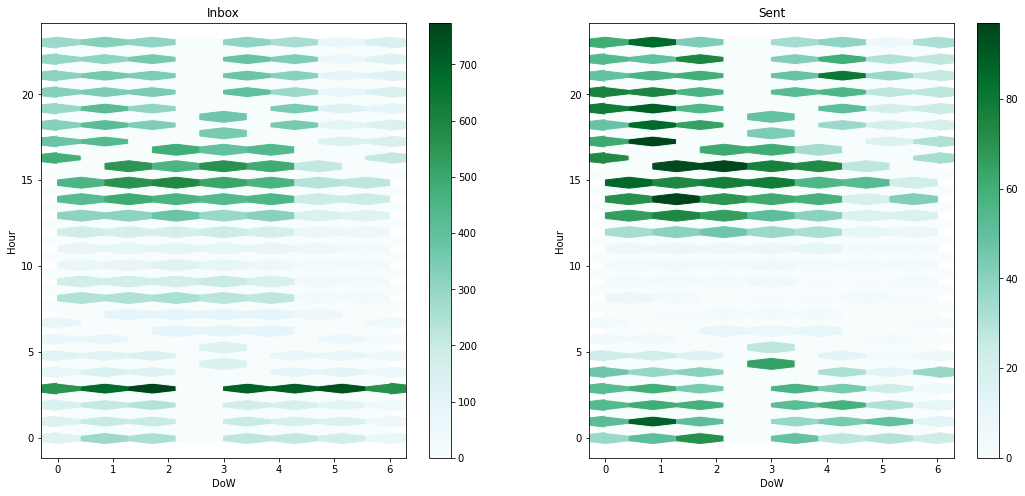

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(18,8))
plot_time_DoW(received,ax1,"Inbox")
plot_time_DoW(sent,ax2,"Sent")

### Length of threads

In [29]:
#Number of unique threads
n_threads=len(gmail_df["X-GM-THRID"].unique())
print(f"There are {n_threads} threads in this mailbox")

There are 36658 threads in this mailbox


In [30]:
thread_count=gmail_df["X-GM-THRID"].value_counts()

Text(0.5, 1.0, 'Distribution of thread length')

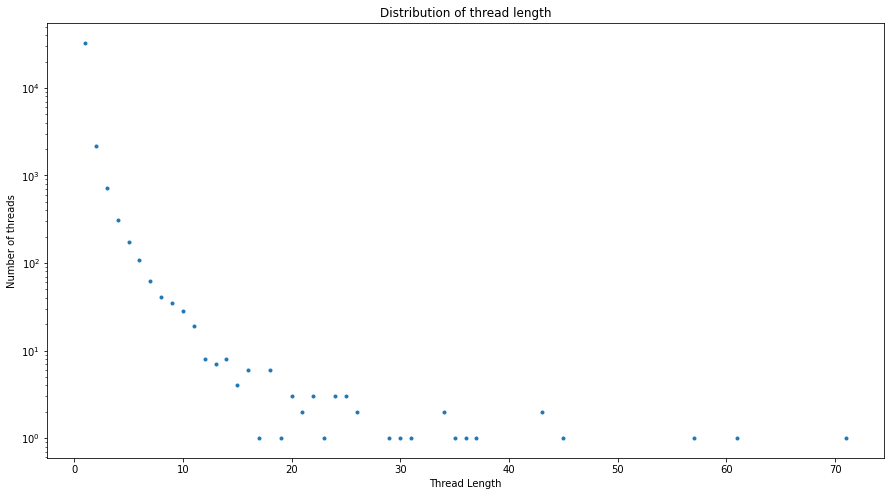

In [31]:
thread_count.value_counts().plot(logy=True,marker=".",linewidth=0,figsize=(15,8))
plt.xlabel("Thread Length")
plt.ylabel("Number of threads")
plt.title("Distribution of thread length")

### Subject Line Topics

(-0.5, 999.5, 599.5, -0.5)

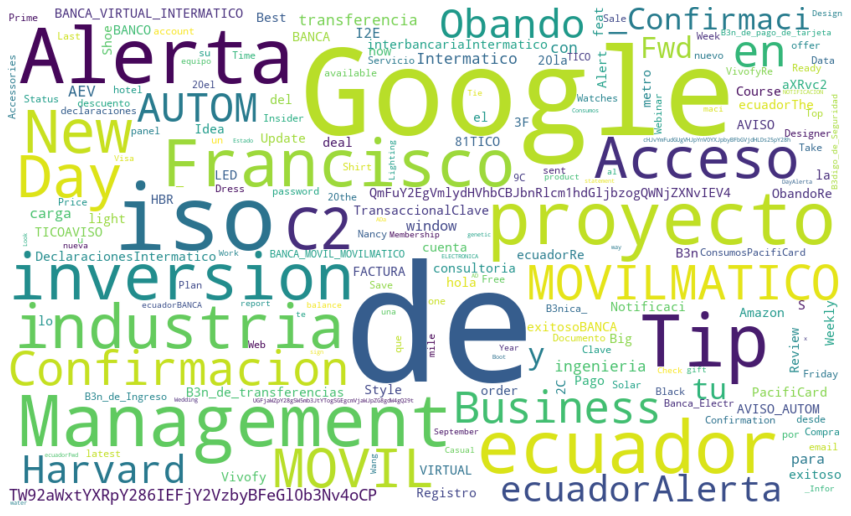

In [69]:
# Accumulate subject lines and generate WordCloud
# From a first review there are plenty of utf, B, F0, 9F
stopwords = set(STOPWORDS)
stopwords.update(["utf","B","F0","9F","C3","Re","Q","RV","igI8","20a","FW","F3n","A0","20y","20to","20en","B3n_C","8d","2D","3A","8J","A1","E2","20de","9a","e"])
subjects = ''.join(map(str,gmail_df["Subject"].to_numpy()))
wordcloud=WordCloud(background_color="white",stopwords=stopwords,repeat=False,collocations=False,width=1000,height=600).generate(subjects)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Most emailed addresses

In [35]:
received["From"].value_counts().head(5)

googlealerts-noreply@google.com      4442
intermail@bancodelpacifico.com.ec    3228
noreply@a.email.hbr.org              1325
infopaci@pacifico.com.ec             1156
notificacion@bancomatico.com.ec      1144
Name: From, dtype: int64

In [36]:
sent["To"].value_counts().head(5)

fran.obando@gmail.com                  615
anapatricia.borja@telefonica.com.ec    312
sebastian.delsalto@gmail.com           201
nanchita@gmail.com                     188
desarrollo@i2e.com.ec                  123
Name: To, dtype: int64

This inbound emails coincides with the word cloud showing Google as a common subject line, this is due to the automated alerts I have set up. Another interesting fact it seems that I have emailed myself quite frequently, usually to keep track of interesting articles or to have access to data, maybe it is time to look into cloud alternatives for this. 

### Peculiarities

In [34]:
gmail_df[gmail_df["To"]==gmail_df["From"]]

,Date,To,From,Subject,Message-ID,Content-Type,X-Gmail-Labels,X-GM-THRID,Hour,DoW,Week,Year,Labels
55,2021-05-13 00:00:29+00:00,comunicaciones@spe-ecuador.org,comunicaciones@spe-ecuador.org,**LINK INGRESO** 13 y 14 de mayo - Conferencia...,<004401d7478b$13ae3850$3b0aa8f0$@spe-ecuador.org>,"multipart/related;\n\tboundary=""----=_NextPart...","Inbox,Opened,Category Updates",1699599181969615133,0,3,19,2021,Inbox
506,2021-06-02 20:20:34+00:00,fran.obando@gmail.com,fran.obando@gmail.com,Excel embajada,<CABYUqTLFBOtiCNqe8uDJAJUkppNk3DjfZVkSPkYw7Rjz...,"multipart/mixed; boundary=""000000000000f86edd0...","Sent,Inbox,Important,Opened",1701487802370484040,20,2,22,2021,Sent
560,2021-04-08 19:52:56+00:00,eborja@funalgodon.org,eborja@funalgodon.org,=?iso-8859-1?Q?_Encuestas_entendiendo_empate_t...,<061001d72cb0$c752af30$55f80d90$@funalgodon.org>,"multipart/mixed;\n\tboundary=""----=_NextPart_0...","Inbox,Important,Opened,Category Personal",1696503255130433702,19,3,14,2021,Inbox
656,2021-06-03 17:06:45+00:00,eborja@funalgodon.org,eborja@funalgodon.org,=?utf-8?Q?_RETENCIONES_DE_IMPUESTO_A_LA_RE?=\n...,<183201d7589a$d911a8a0$8b34f9e0$@funalgodon.org>,"multipart/mixed;\n\tboundary=""----=_NextPart_0...","Inbox,Important,Opened,Category Personal",1701566252979982710,17,3,22,2021,Inbox
714,2021-04-02 11:47:00+00:00,eborja@funalgodon.org,eborja@funalgodon.org,=?iso-8859-1?Q?decreto_ejecutivo_1282__estado_...,<008e01d727b5$e9605f50$bc211df0$@funalgodon.org>,"multipart/mixed;\n\tboundary=""----=_NextPart_0...","Inbox,Important,Opened,Category Personal",1695929110276608929,11,4,13,2021,Inbox
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45878,2014-09-16 05:55:04+00:00,susquared-users@lists.stanford.edu,susquared-users@lists.stanford.edu,Join the SU2 Developer Team,<mailman.29754.1410846907.5962.susquared-users...,"multipart/alternative;\n boundary=""Apple-Mail=...","Inbox,Opened,Category Forums",1479380219389138976,5,1,38,2014,Inbox
45914,2009-12-16 14:12:25+00:00,serrano@itesm.mx,serrano@itesm.mx,=?iso-8859-1?Q?sobre_t=F3picos_aeron=E1utica_y...,<4A2BA0E3015F3354@mailserver3.itesm.mx> (added...,"multipart/mixed;\n\tboundary=""================...","Inbox,IMAP_$NotJunk,Opened",1322225632646271849,14,2,51,2009,Inbox
45915,2009-12-16 14:10:10+00:00,serrano@itesm.mx,serrano@itesm.mx,=?iso-8859-1?Q?sobre_t=F3picos_aeron=E1utica_y...,<4A2BA0E3015F31D8@mailserver3.itesm.mx> (added...,"multipart/alternative;\n\tboundary=""==========...","Inbox,Opened",1322225632646271849,14,2,51,2009,Inbox
45993,2014-08-07 19:50:05+00:00,fran.obando@gmail.com,fran.obando@gmail.com,FOU newsletter,<a5a239075d0b73749d2d27d902f36f4f@fallonus.com>,"multipart/alternative;\n boundary=""_=_swift_v4...","Sent,Inbox,Important,Opened,Category Updates",1475808868867654653,19,3,32,2014,Sent


By looking for email that have the same sender and receiver we can see threads that are either sending myself information, or part of messaging lists where the actual recipients are BCC to prevent sharing emails unintentionally. 

In [71]:
gmail_df[gmail_df["To"]==gmail_df["From"]]["To"].value_counts()

fran.obando@gmail.com                 615
eborja@funalgodon.org                 115
serrano@itesm.mx                       29
chinojos@itesm.mx                      15
susquared-users@lists.stanford.edu     13
                                     ... 
mmt.egade@servicios.itesm.mx            1
petrucco@unimelb.edu.au                 1
fj.obando1649@uniandes.edu.co           1
epsc-abroad@unimelb.edu.au              1
mario.manzano@itesm.mx                  1
Name: To, Length: 61, dtype: int64